In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
import pandas as pd
import torch
import pickle
import math
import prior.CustomDistribution as custom
import config
import time
import IPython.display as IPd

from forward import Forward
from survey import Survey

from util import *
from block_utils import *
from pygimli_utils import *
from polynomials import Polynomial

# SimPEG imports
from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.utils import plot_1d_layer_model
from discretize import TensorMesh

# SBI imports
from sbi.inference import SNPE, SNLE, prepare_for_sbi, simulate_for_sbi, likelihood_estimator_based_potential, \
    MCMCPosterior
from sbi import utils as utils
from sbi.utils import RestrictionEstimator
from sbi.utils import user_input_checks as uic
from sbi import analysis as analysis
from sbi.analysis import check_sbc, run_sbc, get_nltp, sbc_rank_plot

from torch.distributions import Distribution, Uniform, Normal
from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm, ListedColormap

# Imports for Section 10
from scipy.interpolate import lagrange
from random import randrange

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from svgutils.compose import *

_ = torch.manual_seed(0)

2024-08-06 15:10:00.737336: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-06 15:10:00.778594: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-06 15:10:00.778632: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-06 15:10:00.778656: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-06 15:10:00.788102: I tensorflow/core/platform/cpu_feature_g

# Setup Section - Define Parameters and Functions for both models

In [2]:
max_depth = 23.5
step_size = 0.5
num_points = int(max_depth / step_size) + 1
max_resistivity = 1000
min_resistivity = 1
num_measurements = 23
num_dim = 48

depths = np.linspace(0, max_depth, num=num_dim)
thicknesses = torch.ones(num_dim) * 0.5

In [3]:
# Survey Setup and Forward Model Setup

survey, electrode_spacing = Survey(num_measurements, min_ab_distance=2, max_ab_distance=100).schlumberger_survey()
forward = Forward(thicknesses, survey)

### Step Model and Functions

In [4]:
# Helper functions for the Step Model 

def steps_forward_model_no_noise(res):
    ''' 
    Noiseless forward simulator for the step prior 
    '''
    return forward.dc_forward_model(res)


def steps_forward_model_base_noise_5(res):
    ''' 
    Forward simulator for the step prior adding white noise (of magnitude 5 \Omega m) to the simulations 
    '''
    if (np.any([res < 0])):
        nan_array = np.empty((num_measurements,))
        nan_array[:] = np.nan
        return nan_array
    return forward.dc_forward_model_base_noise(res, 5)


# Prior Setup
prior_high_res = max_resistivity
prior_low_res = min_resistivity
custom_prior = custom.CustomDistribution(low=prior_low_res, high=prior_high_res, dimension=num_dim)
prior_step, *_ = uic.process_prior(custom_prior,
                                   custom_prior_wrapper_kwargs=dict(
                                       lower_bound=torch.tensor([custom_prior.low] * custom_prior.dimension),
                                       upper_bound=torch.tensor([custom_prior.high] * custom_prior.dimension)
                                   )
                                   )


/opt/bwhpc/common/jupyter/tensorflow/2023-10-10/lib/python3.9/site-packages/torch/distributions/distribution.py:53: UserWarning: <class 'prior.CustomDistribution.CustomDistribution'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


In [5]:
def compute_cis_and_means_from_step_posterior_sammples(observation):
    '''
    Computation of confidence intervals and mean for posterior samples and posterior predictive samples from step posterior given an observation. 
    100,000 posterior samples are taken from which 1,000 are randomly selected. 
    These posterior samples are evluated under the forward model. 
    The confidencen intervals and posterior (predictive) mean of the 1,000 samples are calculated.

    Returns: 
        posterior samples
        posterior predictive samples
        posterior sample mean
        posterior sample confidence intervals
        posterior predictive sample mean
        posterior predictive sample mean
        posterior predictive sample confidence intervals
    
    '''

    posterior_sample_size = 100_000
    simulation_sample_size = 1_000
    percentiles = config.percentiles

    # Sample from Step posterior
    posterior_samples_step = posterior_step.sample((posterior_sample_size,), x=observation, show_progress_bars=True)

    # Get random samples form the posterior samples
    perm = torch.randperm(posterior_sample_size)
    idx = perm[:simulation_sample_size]
    random_post_samples = posterior_samples_step[idx]

    # Simulate the Apparent Resistivity from the samples
    sim_apparent_resistivities = []
    for sample in random_post_samples:
        app_res = steps_forward_model_base_noise_5(np.array(sample))
        sim_apparent_resistivities.append(app_res)

    # Compute confidence intervals and mean for resistivity depth profile
    conf_intervals_res = np.nanpercentile(random_post_samples, q=percentiles, axis=0)
    mean_res = np.nanmean(random_post_samples, axis=0)

    # Compute confidence intervals and mean in observation space
    conf_intervals_ar = np.nanpercentile(sim_apparent_resistivities, q=percentiles, axis=0)
    mean_ar = np.nanmean(sim_apparent_resistivities, axis=0)

    return random_post_samples, sim_apparent_resistivities, mean_res, conf_intervals_res, mean_ar, conf_intervals_ar

### Polynomial Model and Functions

In [6]:
# Helper functions for the Polynomial Model

def normalize(depths, max_depth):
    '''
    Helper function to normalize the depth profile, such that it is transformed to the interval [-1,1]
    '''
    half_max_depth = max_depth / 2
    return (depths - half_max_depth) / half_max_depth


normalized_depth = normalize(depths, max_depth)


# Legendre Polynomial function
def legendre_polynomial(x, coefficients):
    '''
    For given coefficients (from the prior or posterior) generate the Polynomial function that is composed of the first five Legendre Polynomials, given the coefficients.  
    The polynomial is evaluated on the points described in x.
    
    Returns the values at x of the generated polynomial function.
    '''

    poly = np.polynomial.legendre.Legendre(coefficients)
    return poly(x)


def legendre_polynomial_nan(coefficients):
    '''
    For given coefficients (from the prior or posterior) generate the Polynomial function that is composed of the first five Legendre Polynomials, given the coefficients.  
    The polynomial is evaluated on the points described in x.
    If the polynomial exceeds the range of [-1,1] under which Legendre polynomials are well-defined, an array of nan-values is returned, to mark this sample as invalid. 
    
    Returns the values at x of the generated polynomial function.
    '''
    coefficients = coefficients
    poly = legendre_polynomial(normalized_depth, coefficients)
    if np.any((poly < -1) | (poly > 1)):
        return np.full((normalized_depth.shape[0],), np.nan)
    else:
        return poly


def poly_to_resistivity(poly):
    '''
    Transforms the polynomial values from the interval of [-1,1] to the interval [0 - max_res]
    '''
    return (poly + 1) * (max_resistivity / 2)


def coefficients_to_resistivity(coeff):
    '''
    For a sample of coefficients, the Legendre Polynomial is generated. 
    If the sample is valid (not exceeding the range of [-1,1]) the values are transformed to the resistivity interval. 
    '''

    poly = legendre_polynomial_nan(coeff)
    if np.isnan(poly).all():
        return np.full((num_dim,), np.nan)
    else:
        return poly_to_resistivity(poly)


def legendre_forward_nan(coefficients):
    '''
    Forward simulator for the polynomial prior without noise. 
    Returns the apparent resistivity signal for a set of given coefficients. 
    The polynomial is generated and checked if valid. 
    The apparent resistivity of this depth profile is returned. 
    '''

    poly = legendre_polynomial(normalized_depth, coefficients)
    if np.any((poly < -1) | (poly > 1)):
        return np.full((num_measurements,), np.nan)
    else:
        # Shift from [-1,1] interval to [0,2]
        # Then multiply by max_resistivity/2 value to cover the resistivity value range [0, max_resistivity]
        res = poly_to_resistivity(poly)
        return forward.dc_forward_model(res)


# Interpolate Legendre polynomial coefficients and remove invalid simulations by substitue with nan values
def legendre_forward_nan_noise_5(coefficients):
    '''
    Forward simulator for the polynomial prior with white noise of 5 Ohm m magnitude. 
    Returns the apparent resistivity signal for a set of given coefficients. 
    The polynomial is generated and checked if valid. 
    The apparent resistivity of this depth profile is returned. 
    '''

    poly = legendre_polynomial(normalized_depth, coefficients)
    if np.any((poly < -1) | (poly > 1)):
        return np.full((num_measurements,), np.nan)
    else:
        # Shift from [-1,1] interval to [0,2]
        # Then multiply by max_resistivity/2 value to cover the resistivity value range [0, max_resistivity]
        res = poly_to_resistivity(poly)
        return forward.dc_forward_model_base_noise(res, 5)


# Prior Setup 
num_dim_prior = 5
prior_min = torch.as_tensor([-1] * num_dim_prior)
prior_max = torch.as_tensor([1] * num_dim_prior)
prior_poly = utils.BoxUniform(low=prior_min * torch.ones(num_dim_prior), high=prior_max * torch.ones(num_dim_prior))


In [7]:
def compute_cis_and_means_from_poly_posterior_sammples(observation):
    '''
    Computation of confidence intervals and mean for posterior samples and posterior predictive samples from polynomial posterior given an observation. 
    100,000 posterior samples are taken from which 1,000 are randomly selected. 
    These posterior samples are evluated under the forward model. 
    The confidencen intervals and posterior (predictive) mean of the 1,000 samples are calculated.

    Returns: 
        posterior samples
        posterior predictive samples
        posterior sample mean
        posterior sample confidence intervals
        posterior predictive sample mean
        posterior predictive sample mean
        posterior predictive sample confidence intervals
    
    '''

    posterior_sample_size = 100_000
    simulation_sample_size = 1_000
    percentiles = config.percentiles

    # Sample from Step posterior
    posterior_samples_poly = posterior_poly.sample((posterior_sample_size,), x=observation, show_progress_bars=True)

    # Get random samples form the posterior samples
    perm = torch.randperm(posterior_sample_size)
    idx = perm[:simulation_sample_size]
    random_post_samples = posterior_samples_poly[idx]

    # Simulate the Apparent Resistivity from the samples
    post_resistivities = []
    sim_apparent_resistivities = []
    for sample in random_post_samples:
        post_resistivities.append(coefficients_to_resistivity(sample))
        app_res = legendre_forward_nan_noise_5(np.array(sample))
        sim_apparent_resistivities.append(app_res)

    # Compute confidence intervals for resistivity and the simulated apparent_resistivity
    conf_intervals_res = np.nanpercentile(post_resistivities, q=percentiles, axis=0)
    mean_res = np.nanmean(post_resistivities, axis=0)

    conf_intervals_ar = np.nanpercentile(sim_apparent_resistivities, q=percentiles, axis=0)
    mean_ar = np.nanmean(sim_apparent_resistivities, axis=0)

    return post_resistivities, sim_apparent_resistivities, mean_res, conf_intervals_res, mean_ar, conf_intervals_ar

### Independent Step Model and Functions

In [8]:
def compute_cis_and_means_from_ind_step_posterior_sammples(observation):
    '''
    Computation of confidence intervals and mean for posterior samples and posterior predictive samples from independent step posterior given an observation. 
    100,000 posterior samples are taken from which 1,000 are randomly selected. 
    These posterior samples are evluated under the forward model. 
    The confidencen intervals and posterior (predictive) mean of the 1,000 samples are calculated.

    Returns: 
        posterior samples
        posterior predictive samples
        posterior sample mean
        posterior sample confidence intervals
        posterior predictive sample mean
        posterior predictive sample mean
        posterior predictive sample confidence intervals
    '''

    posterior_sample_size = 100_000
    simulation_sample_size = 1_000
    percentiles = config.percentiles

    # Sample from Step posterior
    posterior_samples_step = posterior_ind_step.sample((posterior_sample_size,), x=observation, show_progress_bars=True)

    # Get random samples form the posterior samples
    perm = torch.randperm(posterior_sample_size)
    idx = perm[:simulation_sample_size]
    random_post_samples = posterior_samples_step[idx]

    # Simulate the Apparent Resistivity from the samples
    sim_apparent_resistivities = []
    for sample in random_post_samples:
        app_res = steps_forward_model_base_noise_5(np.array(sample))
        sim_apparent_resistivities.append(app_res)

    # Compute confidence intervals and mean for resistivity depth profile
    conf_intervals_res = np.nanpercentile(random_post_samples, q=percentiles, axis=0)
    mean_res = np.nanmean(random_post_samples, axis=0)

    # Compute confidence intervals and mean in observation space
    conf_intervals_ar = np.nanpercentile(sim_apparent_resistivities, q=percentiles, axis=0)
    mean_ar = np.nanmean(sim_apparent_resistivities, axis=0)

    return random_post_samples, sim_apparent_resistivities, mean_res, conf_intervals_res, mean_ar, conf_intervals_ar

### Block Model

In [9]:
def split_params(res_n_depth):
    ''' 
    Split a block sample into its resistivity values and the layer thicknesses
    '''
    number_of_layers = int((len(res_n_depth) + 1) / 2)
    # First half of parameters is resistivities
    resistivities = res_n_depth[:number_of_layers]
    # Second half of parameters are thicknesses
    thicknesses = res_n_depth[number_of_layers:]
    return resistivities, thicknesses


def thickness_to_depth(t):
    ''' 
    Convert the individual layer thicknesses to a depth profile as the layers are stacked on top of each other
    '''
    last_layer_tickness = torch.tensor([1.0])
    thickness_to_depth = np.cumsum(torch.cat((t, last_layer_tickness)))
    return thickness_to_depth


def dc_forward_block_noise(res_n_depth):
    '''
    Simulator used for generating the training set (noise level 5 \Omega m)
    returns the apparent resistiviy values from  a block sample. 
    '''
    resistivities, thicknesses = split_params(res_n_depth)
    forward = Forward(thicknesses, survey)

    return forward.dc_forward_model_base_noise(resistivities, 5)


def dc_forward_block_no_noise(res_n_depth):
    '''
    Noiseless Simulator
    returns the apparent resistiviy values from  a block sample. 
    '''
    resistivities, thicknesses = split_params(res_n_depth)
    forward = Forward(thicknesses, survey)

    return forward.dc_forward_model(resistivities)


def ensure_48_points(block_res):
    '''    
    Check if the depth profile has 48 values. If depth profile is too short, extend the last layers -> used for plotting
    in case the model has 48 points it is not modified. If it has less, the resistivity values of the last layer are appenden to ensure 48 points.
    
    Return block resistivities
    '''
    # Check if the array has less than 48 values
    while len(block_res) < 48:
        # Append the last value to the array until it has 48 values
        block_res.append(block_res[-1])
    return np.array(block_res)


def block_sample_to_resistivity(sample):
    '''
    Transforms a block prior or posterior sample into the resistivity depth profile.
    The sample is splitted into layer thicknesses and resistivity values. 
    From this a depth profile of at least 48 steps is generated that representens the resistivities at small layer steps of 0.5m 
    to compare to other depth profiles of other priors or posteriors
    
    Returns the block resistivity depth profile from a block sample. 
    '''
    inv_res_thick_depth, max_depth = transfrom_and_find_max_reached_depth([sample])
    mapped_sample = map_resistivities_to_depth(inv_res_thick_depth, max_depth)
    low_res_sample = transform_to_lower_res_samples(mapped_sample)[0]
    return ensure_48_points(low_res_sample)


def compute_avg_rmse_and_map_rsme_from_block_posterior_sammples(gt_res, gt_app_res):
    '''
    Computation of error metrics: 
    The posterior ist samples 10,000 times from which 1,000 samples are evaluated under the forward model. 
    Among the 1,000 posterior predictive samples the minimal RMSE is assessed. 
    The respective RMSE of the posterior sample that belongs to the minimal RMSE prediction is caluculated.
    The average error over all posterior samples and posterior predictive samples is computed. 

    For comparison with the minimal RMSEs the MAP sample and it's prediction is computed and the RMSEs are calculated.

    returns all error metrics
    '''
    posterior_sample_size = 10_000
    simulation_sample_size = 1_000
    percentiles = config.percentiles

    posterior_block.set_default_x(gt_app_res)
    # Sample from Step posterior
    posterior_samples_block = posterior_block.sample((posterior_sample_size,), show_progress_bars=True)

    # Get random samples form the posterior samples
    perm = torch.randperm(posterior_sample_size)
    idx = perm[:simulation_sample_size]
    random_post_samples = posterior_samples_block[idx]

    # Simulate the Apparent Resistivity from the samples
    post_resistivities = []
    sim_apparent_resistivities = []
    min_rmse_ar = np.infty
    min_rmse_res = np.infty

    for sample in random_post_samples:
        app_res = dc_forward_block_no_noise(np.array(sample))
        res = block_sample_to_resistivity(sample)
        rmse_value_ar = rmse(app_res, gt_app_res)

        if rmse_value_ar <= min_rmse_ar:
            min_rmse_ar = rmse_value_ar
            min_rmse_res = rmse(res, gt_res)
        sim_apparent_resistivities.append(app_res)
        post_resistivities.append(res)

    print("Min RMSE is: ", min_rmse_ar)
    mean_res = np.nanmean(post_resistivities, axis=0)
    mean_ar = np.nanmean(sim_apparent_resistivities, axis=0)

    avg_rmse_param = avg_rmse(gt_res, post_resistivities)
    avg_rmse_obs = avg_rmse(gt_app_res, sim_apparent_resistivities)

    map = posterior_block.map()[0]
    map_app_res = dc_forward_block_no_noise(np.array(map))

    map_rmse_res = rmse(block_sample_to_resistivity(map), gt_res)
    map_rmse_app_res = rmse(map_app_res, gt_app_res)

    return min_rmse_ar, min_rmse_res, mean_res, mean_ar, avg_rmse_param, avg_rmse_obs, map, map_app_res, map_rmse_res, map_rmse_app_res


def compute_cis_and_means_from_block_posterior_sammples(observation):
    '''
    Computation of confidence intervals and mean for posterior samples and posterior predictive samples from block posterior given an observation. 
    100,000 posterior samples are taken from which 1,000 are randomly selected. 
    These posterior samples are evluated under the forward model. 
    The confidencen intervals and posterior (predictive) mean of the 1,000 samples are calculated.

    Returns: 
        posterior samples
        posterior predictive samples
        posterior sample mean
        posterior sample confidence intervals
        posterior predictive sample mean
        posterior predictive sample mean
        posterior predictive sample confidence intervals
    '''

    posterior_sample_size = 100_000
    simulation_sample_size = 1_000
    percentiles = config.percentiles

    # Sample from Step posterior
    posterior_samples_step = posterior_block.sample((posterior_sample_size,), x=observation, show_progress_bars=True)

    # Get random samples form the posterior samples
    perm = torch.randperm(posterior_sample_size)
    idx = perm[:simulation_sample_size]
    random_post_samples = posterior_samples_step[idx]

    inv_res_thick_depth, max_depth = transfrom_and_find_max_reached_depth(random_post_samples)
    trans_res_samples = map_resistivities_to_depth(inv_res_thick_depth, max_depth)

    # Simulate the Apparent Resistivity from the samples
    sim_apparent_resistivities = []
    for sample in random_post_samples:
        app_res = dc_forward_block_noise(np.array(sample))
        sim_apparent_resistivities.append(app_res)

    # Compute confidence intervals and mean for resistivity depth profile
    conf_intervals_res = np.nanpercentile(trans_res_samples, q=percentiles, axis=0)
    mean_res = np.nanmean(trans_res_samples, axis=0)

    # Compute confidence intervals and mean in observation space
    conf_intervals_ar = np.nanpercentile(sim_apparent_resistivities, q=percentiles, axis=0)
    mean_ar = np.nanmean(sim_apparent_resistivities, axis=0)

    return random_post_samples, trans_res_samples, sim_apparent_resistivities, mean_res, conf_intervals_res, mean_ar, conf_intervals_ar


## Load all posterior models

In [10]:
# **** Step prior
filename_step_model = "pickled_objects/steps_100k_1000_ohm_48points_new.pkl"
inference_step, posterior_step = unpickle_objects(filename_step_model)

# **** Polynomial Prior
filename_legendre_model = "pickled_objects/legendre_100k_1000_ohm_48points_new.pkl"
inference_poly, posterior_poly = unpickle_objects(filename_legendre_model)

# **** Independent Step Prior
filename_ind_steps_model = "pickled_objects/ind_steps_500k_1000_ohm_48points.pkl"
inference_ind_step, posterior_ind_step = unpickle_objects(filename_ind_steps_model)

# **** Block Prior 
filename_block_model = "pickled_objects/block_100k_1000_ohm_48points.pkl"
inference_block, posterior_block = unpickle_objects(filename_block_model)

# Load the Data that is confirmed by drilling

In [12]:
xls = pd.ExcelFile('data/terrana/drilling_confirmed_survey.xls')
df = pd.read_excel(xls, 'Messwerte', index_col=0)

# *** Site 5 close to BK4
observation = (
    df.loc[df.index == 5]
    .stack()
    .groupby(level=1)
    .first()
    .loc[2:100]
    .astype(float)
    .values
)

# Load the Inversion Results 

# 4 Layer Inversion
model_layer4, inv_response_layer4 = unpickle_objects(
    'data/inversion/real_data/pygimli-inversion-drilling-observation-layer4.pkl')

# 5 Layer Inversion
model_layer5, inv_response_layer5 = unpickle_objects(
    'data/inversion/real_data/pygimli-inversion-drilling-observation-layer5.pkl')

# 48 Layer Inversion
model_layer48, inv_response_layer48 = unpickle_objects(
    'data/inversion/real_data/pygimli-inversion-drilling-observation-layer48.pkl')



In [13]:
inv_res_4 = process_gimli_results(model_layer4)
inv_res_5 = process_gimli_results(model_layer5)
inv_res_48 = process_gimli_results(model_layer48)

## Evaluation of VES confirmed by sediment core

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

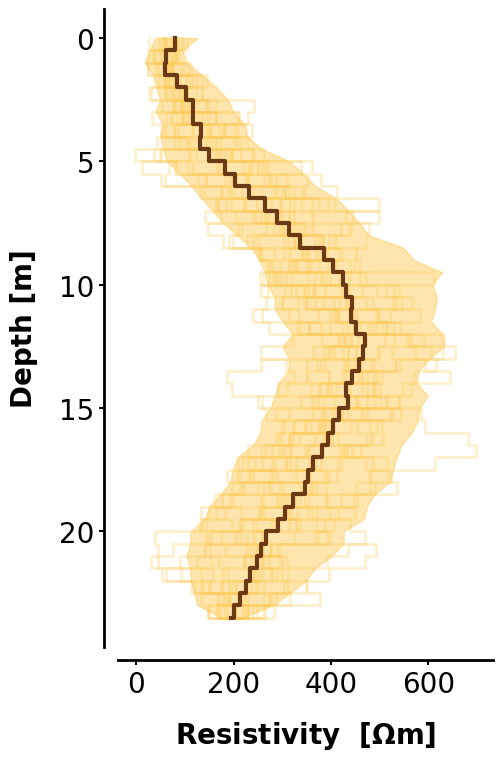

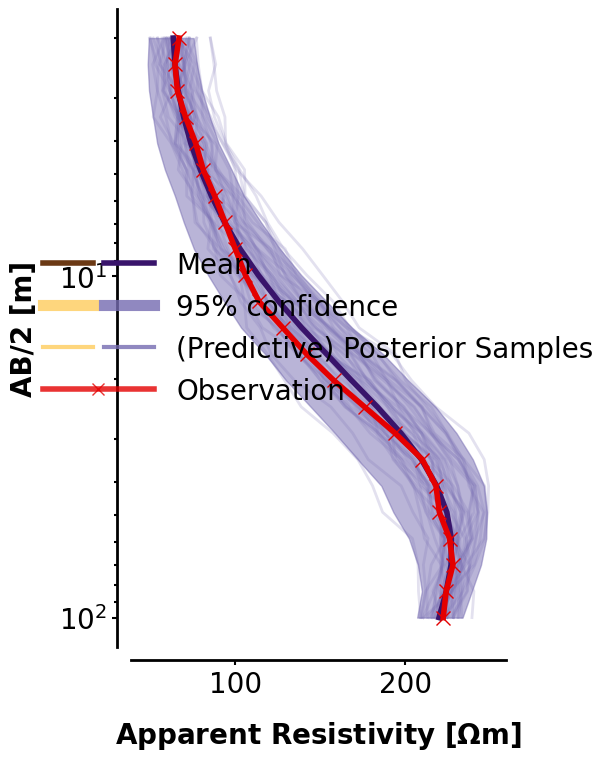

In [14]:
random_post_samples_step, sim_apparent_resistivities_step, mean_res_step, conf_intervals_res_step, mean_ar_step, conf_intervals_ar_step = compute_cis_and_means_from_step_posterior_sammples(
    observation)

plot_depth_profile_with_ci(
    res_samples=random_post_samples_step,
    gt_res=None,
    mean_res=mean_res_step,
    conf_intervals_res=conf_intervals_res_step,
    pygimli_res=None,  #[(inv_res_4,4), (inv_res_5,5), (inv_res_41,41)],
    filename='real_data/depth_ebel_step_5_BK4_48points.svg',
    step=True,
    mean_step=True,
    yaxis_label=True,
)

plot_app_res_with_ci(
    app_res_samples=sim_apparent_resistivities_step,
    gt_app_res=observation,
    mean_app_res=mean_ar_step,
    conf_intervals_app_res=conf_intervals_ar_step,
    pygimli_app_res=None,  #[(inv_response_layer4,4), (inv_response_layer5,5), (inv_response_ebel_5_layer41,41)],
    filename='real_data/app_res_ebel_step_5_BK4_48points.svg',
    yaxis_label=True,
    legend=True
)

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

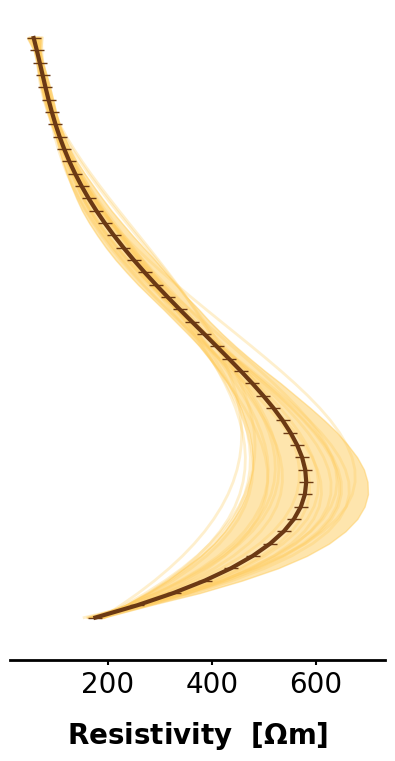

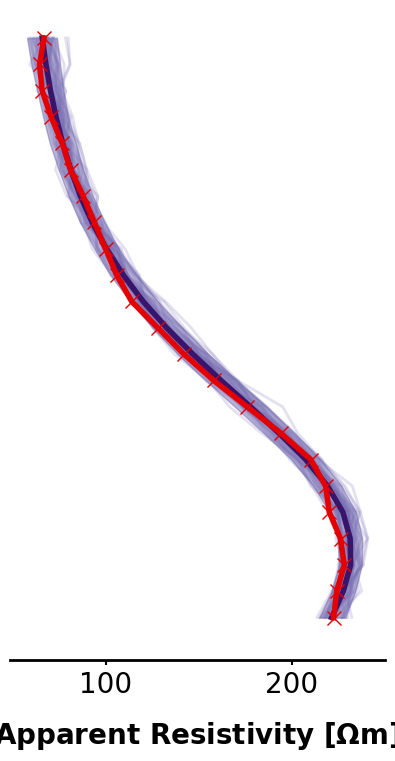

In [15]:
post_resistivities_poly, sim_apparent_resistivities_poly, mean_res_poly, conf_intervals_res_poly, mean_ar_poly, conf_intervals_ar_poly = compute_cis_and_means_from_poly_posterior_sammples(
    observation)

plot_depth_profile_with_ci(
    res_samples=post_resistivities_poly,  #post_resistivities_poly,
    gt_res=None,
    pygimli_res=None,  #[(inv_res_4,4), (inv_res_5,5), (inv_res_41,41)],
    mean_res=mean_res_poly,
    conf_intervals_res=conf_intervals_res_poly,
    filename='real_data/depth_ebel_poly_5_BK4_48points_new.svg',
    yaxis_label=False,
    yaxis_visible=False
)

plot_app_res_with_ci(
    app_res_samples=sim_apparent_resistivities_poly,
    gt_app_res=observation,
    mean_app_res=mean_ar_poly,
    pygimli_app_res=None,  #[(inv_response_layer4,4), (inv_response_layer5,5), (inv_response_ebel_5_layer41,41)],
    conf_intervals_app_res=conf_intervals_ar_poly,
    filename='real_data/app_res_ebel_poly_5_BK4_48points_new.svg',
    yaxis_label=False,
    yaxis_visible=False
)

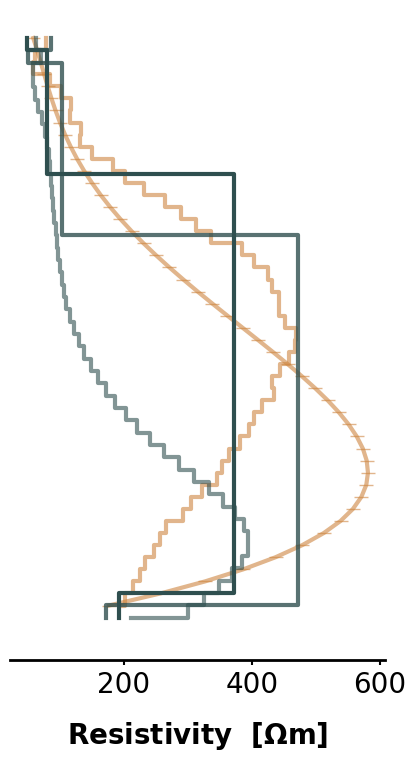

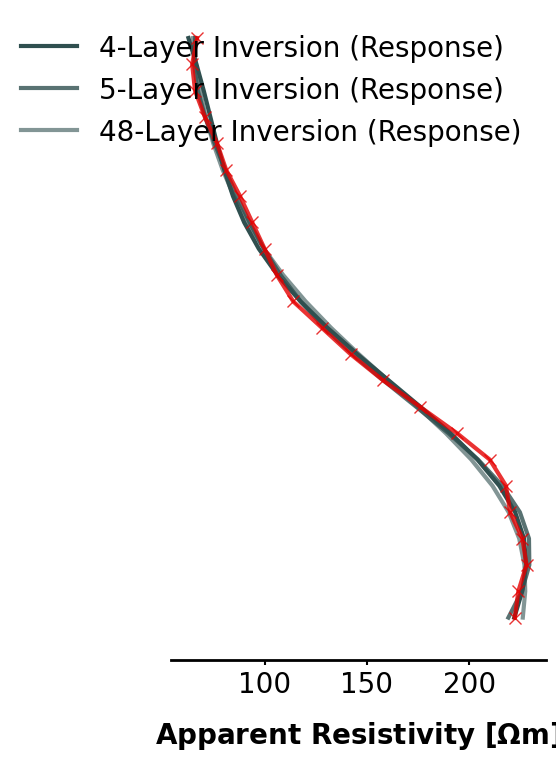

In [16]:
plot_pygimli_depth_results(
    pygimli_res=[(inv_res_4, 4), (inv_res_5, 5), (inv_res_48, 48)],
    filename='real_data/pygimli_depth_ebel_step_5_BK4_48points_48inv.svg',
    step_profile=mean_res_step,
    poly_profile=mean_res_poly,
    yaxis_visible=False
)

plot_pygimli_responses(
    gt_app_res=observation,
    pygimli_app_res=[(inv_response_layer4, 4), (inv_response_layer5, 5), (inv_response_layer48, 48)],
    filename='real_data/pygimli_app_res_ebel_step_5_BK4_48points_48inv.svg',
    legend=True,
    yaxis_visible=False
)

In [18]:
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '14pt', 'weight': '800'}
kwargs_text_light = {'size': '10pt', 'weight': '600'}

f = Figure("50cm", "40cm",

           Panel(
               SVG("plots/real_data/pygimli_depth_ebel_step_5_BK4_48points_48inv.svg").scale(svg_scale),
               Text("d", -20, 50, **kwargs_text)
           ).move(940, 20),

           Panel(
               SVG("plots/real_data/pygimli_app_res_ebel_step_5_BK4_48points_48inv.svg").scale(svg_scale),
               Text("g", -20, 50, **kwargs_text)
           ).move(940, 720),

           Panel(
               SVG("plots/real_data/app_res_ebel_step_5_BK4_48points.svg").scale(svg_scale),
               Text("e", -20, 50, **kwargs_text)
           ).move(40, 720),

           Panel(
               SVG("plots/real_data/app_res_ebel_poly_5_BK4_48points_new.svg").scale(svg_scale),
               Text("f", -20, 50, **kwargs_text)
           ).move(530, 720),

           Panel(
               SVG("plots/real_data/depth_ebel_step_5_BK4_48points.svg").scale(svg_scale),
               Text("b", -10, 50, **kwargs_text)
           ).move(40, 20),

           Panel(
               SVG("plots/real_data/depth_ebel_poly_5_BK4_48points_new.svg").scale(svg_scale),
               Text("c", -20, 50, **kwargs_text)
           ).move(530, 20),
           )

f.save("plots/figures/fig1/ebel_beller_site_5_joint_plots_new_color.svg")
svg("plots/figures/fig1/ebel_beller_site_5_joint_plots_new_color.svg")

In [19]:
print(np.sqrt(mean_squared_error(observation, inv_response_layer4)))
print(np.sqrt(mean_squared_error(observation, inv_response_layer5)))
print(np.sqrt(mean_squared_error(observation, inv_response_layer48)))

2.8789255948861885
2.4064970784813404
3.6679296850879193


In [20]:
print(np.sqrt(mean_squared_error(observation, mean_ar_step)))
print(np.sqrt(mean_squared_error(observation, mean_ar_poly)))

5.497602034610311
3.430417488730577


##### Independent Step Model

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

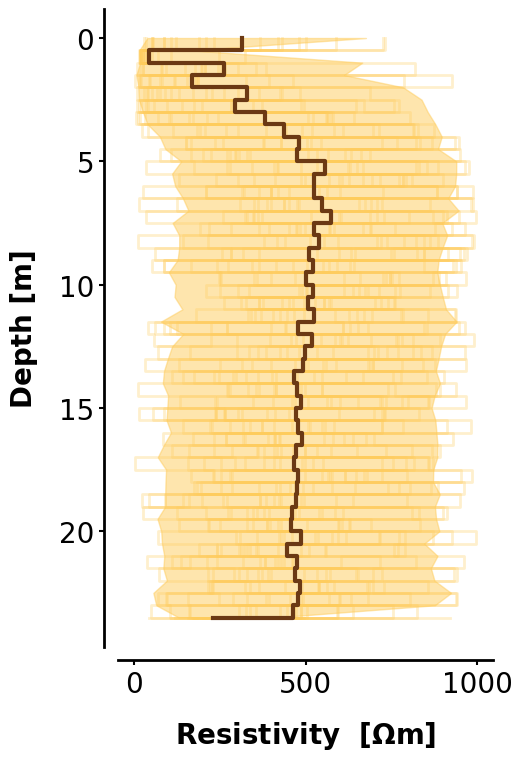

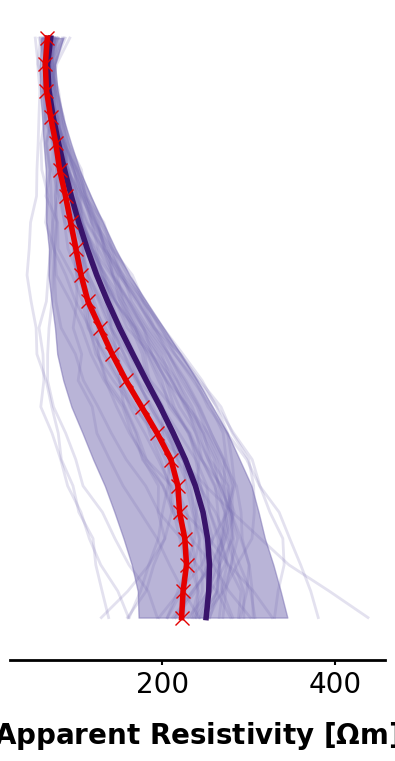

In [21]:
post_resistivities_ind_step, sim_apparent_resistivities_ind_step, mean_res_ind_step, conf_intervals_res_ind_step, mean_ar_ind_step, conf_intervals_ar_ind_step = compute_cis_and_means_from_ind_step_posterior_sammples(
    observation)

plot_depth_profile_with_ci(
    res_samples=post_resistivities_ind_step,
    gt_res=None,
    pygimli_res=None,  #[(inv_res_4,4), (inv_res_5,5), (inv_res_41,41)],
    mean_res=mean_res_ind_step,
    conf_intervals_res=conf_intervals_res_ind_step,
    filename='real_data/depth_ebel_ind_step_5_BK4_48points.svg',
    yaxis_label=True,
    yaxis_visible=True,
    step=True,
    mean_step=True
)

plot_app_res_with_ci(
    app_res_samples=sim_apparent_resistivities_ind_step,
    gt_app_res=observation,
    mean_app_res=mean_ar_ind_step,
    pygimli_app_res=None,  #[(inv_response_layer4,4), (inv_response_layer5,5), (inv_response_ebel_5_layer41,41)],
    conf_intervals_app_res=conf_intervals_ar_ind_step,
    filename='real_data/app_res_ebel_ind_step_5_BK4_48points.svg',
    yaxis_label=False,
    yaxis_visible=False
)

##### Block Model

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

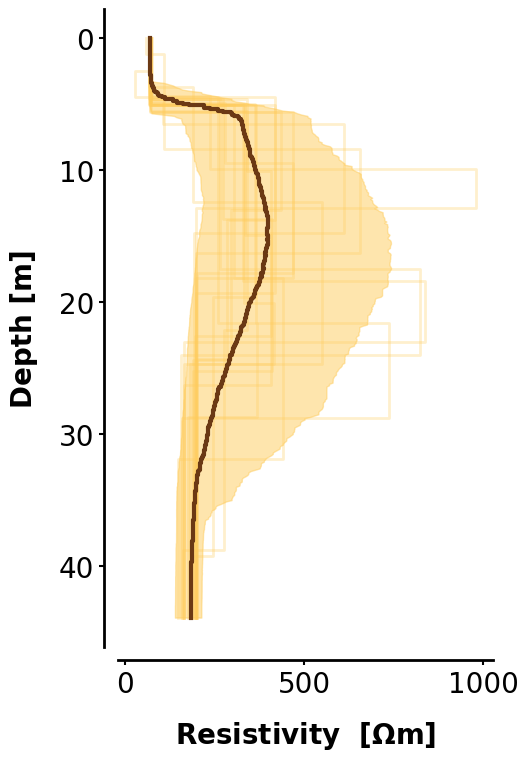

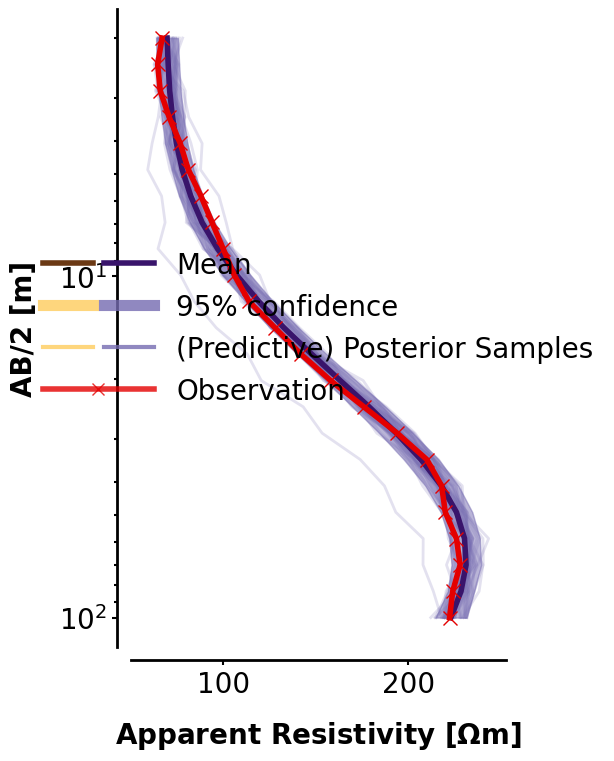

In [22]:
post_resistivities_block, trans_res_samples, sim_apparent_resistivities_block, mean_res_block, conf_intervals_res_block, mean_ar_block, conf_intervals_ar_block = compute_cis_and_means_from_block_posterior_sammples(
    observation)

plot_block_depth_results(
    res_samples=trans_res_samples,
    gt_res=None,
    mean_res=mean_res_block,
    conf_intervals_res=conf_intervals_res_block,
    filename='real_data/depth_ebel_block_5_BK4_48points.svg',
    yaxis_label=True,
    yaxis_visible=True,
    step=True,
    mean_step=True
)

plot_app_res_with_ci(
    app_res_samples=sim_apparent_resistivities_block,
    gt_app_res=observation,
    mean_app_res=mean_ar_block,
    pygimli_app_res=None,  #[(inv_response_layer4,4), (inv_response_layer5,5), (inv_response_ebel_5_layer41,41)],
    conf_intervals_app_res=conf_intervals_ar_block,
    filename='real_data/app_res_ebel_block_5_BK4_48points.svg',
    yaxis_label=True,
    yaxis_visible=True,
    legend=True
)

In [29]:
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '14pt', 'weight': '800'}
kwargs_text_light = {'size': '10pt', 'weight': '600'}

f = Figure("50cm", "40cm",

           Panel(
               SVG("plots/real_data/pygimli_depth_ebel_step_5_BK4_48points_48inv.svg").scale(svg_scale),
               Text("d", -20, 50, **kwargs_text)
           ).move(1040, 20),

           Panel(
               SVG("plots/real_data/pygimli_app_res_ebel_step_5_BK4_48points_48inv.svg").scale(svg_scale),
               Text("g", -20, 50, **kwargs_text)
           ).move(940, 720),

           Panel(
               SVG("plots/real_data/app_res_ebel_block_5_BK4_48points.svg").scale(svg_scale),
               Text("e", -20, 50, **kwargs_text)
           ).move(40, 720),

           Panel(
               SVG("plots/real_data/app_res_ebel_ind_step_5_BK4_48points.svg").scale(svg_scale),
               Text("f", -20, 50, **kwargs_text)
           ).move(530, 720),

           Panel(
               SVG("plots/real_data/depth_ebel_block_5_BK4_48points.svg").scale(svg_scale),
               Text("b", -10, 50, **kwargs_text)
           ).move(40, 20),

           Panel(
               SVG("plots/real_data/depth_ebel_ind_step_5_BK4_48points.svg").scale(svg_scale),
               Text("c", -20, 50, **kwargs_text)
           ).move(530, 20),
           )

f.save("plots/figures/fig1/ebel_beller_site_5_joint_plots_block_ind_step_legend.svg")
svg("plots/figures/fig1/ebel_beller_site_5_joint_plots_block_ind_step_legend.svg")

## Compute the RMSE values

In [24]:
rmses_step = []
for pos_pred_sample in sim_apparent_resistivities_step:
    if not np.isnan(pos_pred_sample).all():
        rmses_step.append(rmse(observation, pos_pred_sample))
    else:
        rmses_step.append(np.infty)

#rmses = [rmse(observation, pos_pred_sample) for pos_pred_sample in sim_apparent_resistivities_step]

In [25]:
def compute_min_rmse(gt_app_res, post_pred_samples):
    rmses = []
    for pos_pred_sample in post_pred_samples:
        if not np.isnan(pos_pred_sample).all():
            rmses.append(rmse(observation, pos_pred_sample))
        else:
            rmses.append(np.infty)
    return np.min(rmses)


In [26]:
print(np.sqrt(mean_squared_error(observation, inv_response_layer4)))
print(np.sqrt(mean_squared_error(observation, inv_response_layer5)))
print(np.sqrt(mean_squared_error(observation, inv_response_layer48)))

2.8789255948861885
2.4064970784813404
3.6679296850879193


In [27]:
print('Min RMSE step model: ', compute_min_rmse(observation, sim_apparent_resistivities_step))
print('Min RMSE poly model: ', compute_min_rmse(observation, sim_apparent_resistivities_poly))
print('Min RMSE block model: ', compute_min_rmse(observation, sim_apparent_resistivities_block))
print('Min RMSE ind. step model: ', compute_min_rmse(observation, sim_apparent_resistivities_ind_step))
print('Min RMSE 4-layer det model: ', rmse(observation, inv_response_layer4))
print('Min RMSE 5-layer det model: ', rmse(observation, inv_response_layer5))
print('Min RMSE 48-layer det model: ', rmse(observation, inv_response_layer48))

Min RMSE step model:  2.77313130604059
Min RMSE poly model:  2.972603776828063
Min RMSE block model:  3.4488743111052873
Min RMSE ind. step model:  2.6813382491193383
Min RMSE 4-layer det model:  2.8789255948861885
Min RMSE 5-layer det model:  2.4064970784813404
Min RMSE 48-layer det model:  3.6679296850879193


In [28]:
print('Avg. RMSE step model: ', avg_rmse(observation, sim_apparent_resistivities_step))
print('Avg. RMSE poly model: ', avg_rmse(observation, sim_apparent_resistivities_poly))
print('Avg. RMSE block model: ', avg_rmse(observation, sim_apparent_resistivities_block))
print('Avg. RMSE ind. step model: ', avg_rmse(observation, sim_apparent_resistivities_ind_step))

Avg. RMSE step model:  14.797393454827422
Avg. RMSE poly model:  5.431635347252928
Avg. RMSE block model:  6.217723289466426
Avg. RMSE ind. step model:  36.628705347773156
